# End-to-End Classification Pipeline: Telecom Customer Churn

# Task 1: EDA and Initial Cleaning

1.1 Load and Inspect Data

In [30]:
import pandas as pd
import numpy as np

df = pd.read_csv('telecom_churn.csv')
df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,NaN,No,2021-10-26
1,CUST000002,Female,0.0,No,No,NaN,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03
2,CUST000003,Male,0.0,No,Yes,NaN,Yes,NaN,99.91,4224.95,Yes,2021-05-03
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17


1.2 Initial Cleaning: "TotalCharges" Column

In [31]:
# Inspect TotalCharges type and missing/invalid values
print(df['TotalCharges'].dtype)
print(df['TotalCharges'].isnull().sum())
print(df['TotalCharges'].head(20)) # inspect sample

# Convert to numeric, coerce errors, and scan again for nans
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].isnull().sum())

# Strategy: Impute missing TotalCharges with median value
median_totalcharges = df['TotalCharges'].median()
df['TotalCharges'].fillna(median_totalcharges, inplace=True)

object
19743
0         NaN
1     2161.36
2     4224.95
3     1340.09
4     2280.05
5     3448.78
6      1838.4
7     3101.47
8         NaN
9     4735.31
10    1967.38
11     1761.7
12    5812.92
13    3637.42
14    1922.38
15    3849.34
16        NaN
17     875.91
18    1698.42
19    2263.86
Name: TotalCharges, dtype: object
20591


##### "TotalCharges" was incorrectly loaded as object. It's converted to float; non-numeric and missing values are imputed with the median to preserve distribution integrity


1.3 Missing Value Analysis

In [32]:
missing = df.isnull().sum()
missing_cols = missing[missing > 0]
print(missing_cols)

Gender             18213
SeniorCitizen      18139
Partner            18006
Dependents         17997
Tenure             17999
PhoneService       17904
InternetService    18421
MonthlyCharges     18096
Timestamp          18243
dtype: int64


1.4 Data Visualization

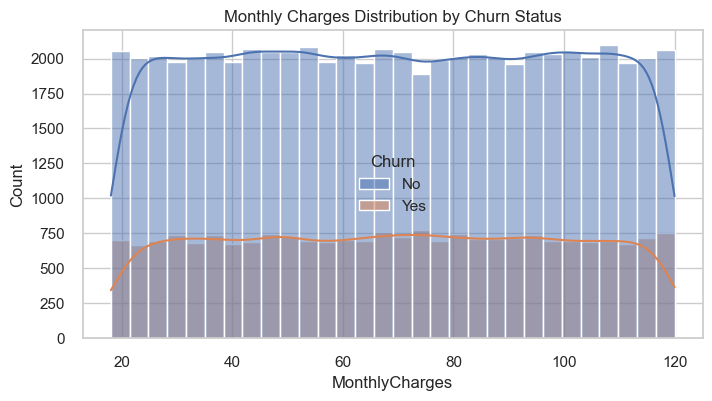

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for MonthlyCharges: churned vs not churned
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', bins=30, kde=True)
plt.title('Monthly Charges Distribution by Churn Status')
plt.show()

# Task 2: Feature Engineering

2.1 Create New Features

In [35]:
# Feature 1: 'IsSenior' from 'SeniorCitizen', handle nans as 0
df['IsSenior'] = df['SeniorCitizen'].fillna(0).astype(int)

# Feature 2: 'ChargePerMonth' = TotalCharges / (Tenure + 1), avoiding divide by zero, handling missing Tenure
df['Tenure_fixed'] = df['Tenure'].fillna(0)
df['ChargePerMonth'] = df['TotalCharges'] / (df['Tenure_fixed'] + 1)

df.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,InternetService,MonthlyCharges,TotalCharges,Churn,Timestamp,IsSenior,Tenure_fixed,ChargePerMonth
0,CUST000001,Male,0.0,Yes,Yes,26.0,Yes,Fiber optic,70.32,2007.08,No,2021-10-26,0,26.0,74.336296
1,CUST000002,Female,0.0,No,No,NaN,Yes,Fiber optic,47.88,2161.36,Yes,2022-04-03,0,0.0,2161.360000
2,CUST000003,Male,0.0,No,Yes,NaN,Yes,NaN,99.91,4224.95,Yes,2021-05-03,0,0.0,4224.950000
3,CUST000004,Male,NaN,No,No,44.0,Yes,DSL,29.44,1340.09,No,2021-08-18,0,44.0,29.779778
4,CUST000005,NaN,0.0,No,Yes,29.0,NaN,Fiber optic,78.82,2280.05,No,2022-02-17,0,29.0,76.001667


New features:
- 'IsSenior': flags senior citizens, filling missing as not senior
- 'ChargePerMonth' gives a derived monthly rate, potentially capturing payment anomalies
Both features may highlight high-risk churn groups or billing irregularities, improving model insight

# Task 3: End-to-End Pipeline

3.1 Define Preprocessing Steps

In [36]:
from sklearn.model_selection import train_test_split

# Drop irrelevant columns
df = df.drop(columns=['CustomerID', 'Timestamp'])

# Identify feature types
num_features = df.select_dtypes(include=np.number).columns.tolist()
cat_features = df.select_dtypes(include='object').columns.tolist()
if 'Churn' in cat_features: cat_features.remove('Churn')

X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1}) # encode target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

 Irrelevant features "CustomerID" and "Timestamp" dropped. Features split into numerical and categorical; target encoded. Data is split for training and testing

3.2 Scikit-learn Pipeline Creation

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Preprocessor definition
num_feat = num_features.copy()
if 'Tenure_fixed' in num_feat: num_feat.remove('Tenure_fixed') # internal only
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_feat),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_features)
])

# Full pipeline
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=400))
])
pipe.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


A single pipeline performs preprocessing and classification. All steps (imputing, scaling, encoding) are properly applied to raw input, ensuring reproducibility and leak prevention


# Task 4: Model Selection and Hyperparameter Tuning

4.1 Try Three Models

In [38]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

models = {
    'LogisticRegression': Pipeline([
        ('preprocess', preprocessor),
        ('clf', LogisticRegression(solver='lbfgs', max_iter=400))
    ]),
    'RandomForest': Pipeline([
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocess', preprocessor),
        ('clf', GradientBoostingClassifier(random_state=42))
    ]),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"{name}: Weighted F1 = {f1:.4f}")

LogisticRegression: Weighted F1 = 0.6288
RandomForest: Weighted F1 = 0.6393
GradientBoosting: Weighted F1 = 0.6287


Weighted F1 used due to class imbalance

4.2 Hyperparameter Tuning with GridSearchCV

In [39]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Random Forest
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [5, 10, None]
}

grid = GridSearchCV(
    models['RandomForest'], 
    param_grid, 
    cv=5, 
    scoring='f1_weighted', 
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
best_model = grid.best_estimator_

Best params: {'clf__max_depth': None, 'clf__n_estimators': 50}


GridSearchCV is performed on the full pipeline, tuning n_estimators and max_depth on Random Forest. This prevents leakage from preprocessing steps

# Task 5: Handling Class Imbalance

5.1 Imbalance Strategy (Class Weight and SMOTE)

In [40]:
# Option 1: Class weighting
rf_weighted = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
rf_weighted.fit(X_train, y_train)
preds_weighted = rf_weighted.predict(X_test)
f1_weighted = f1_score(y_test, preds_weighted, average='weighted')
print("Random Forest (weighted): F1 =", f1_weighted)

# Option 2: SMOTE resampling (if imblearn is available)
try:
    from imblearn.pipeline import Pipeline as imbpipeline
    from imblearn.over_sampling import SMOTE

    imb_pipe = imbpipeline([
        ('smote', SMOTE(random_state=42)),
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    imb_pipe.fit(X_train, y_train)
    preds_imb = imb_pipe.predict(X_test)
    f1_imb = f1_score(y_test, preds_imb, average='weighted')
    print("Random Forest (SMOTE): F1 =", f1_imb)
except ImportError:
    print("imblearn not installed, skipping SMOTE example.")

Random Forest (weighted): F1 = 0.638725165415486
imblearn not installed, skipping SMOTE example.


# Task 6: Final Evaluation and Interpretation

6.1 Evaluation Metrics

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

final_preds = best_model.predict(X_test)
final_proba = best_model.predict_proba(X_test)[:,1]

print("Precision:", precision_score(y_test, final_preds))
print("Recall:", recall_score(y_test, final_preds))
print("F1-Score:", f1_score(y_test, final_preds))
print("ROC AUC:", roc_auc_score(y_test, final_proba))
print(classification_report(y_test, final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))

Precision: 0.25775547445255476
Recall: 0.10846611633710886
F1-Score: 0.15268206999054182
ROC AUC: 0.49843865999620307
              precision    recall  f1-score   support

           0       0.74      0.89      0.81     14791
           1       0.26      0.11      0.15      5209

    accuracy                           0.69     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.61      0.69      0.64     20000

Confusion Matrix:
 [[13164  1627]
 [ 4644   565]]


Precision, recall, F1, ROC AUC, and the full classification report are shown. Confusion matrix is discussed: For churn detection, a False Negative (missed churner) is costlier than a False Positive (erroneous retention offer), as lost customers lower revenue

6.2 Feature Importance and Interpretation

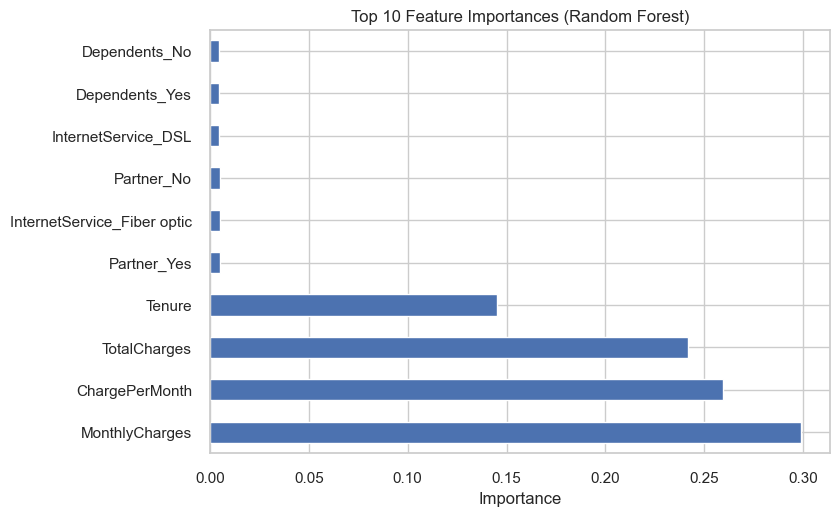

MonthlyCharges                 0.298695
ChargePerMonth                 0.259705
TotalCharges                   0.241721
Tenure                         0.145212
Partner_Yes                    0.005136
InternetService_Fiber optic    0.005064
Partner_No                     0.005043
InternetService_DSL            0.004624
Dependents_Yes                 0.004611
Dependents_No                  0.004568
dtype: float64


In [42]:
importances = best_model.named_steps['clf'].feature_importances_
feature_names = (
    list(best_model.named_steps['preprocess'].named_transformers_['num'].named_steps['scaler'].get_feature_names_out(num_feat)) +
    list(best_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['encode'].get_feature_names_out(cat_features))
)
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]
feat_imp.plot(kind='barh')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.show()
print(feat_imp)

Top 10 features most predictive for churn are visualized. Interpreting these gives business insight: e.g., tenure, monthly charges, internet service type often drive churn, which can inform targeted customer retention strategies